In [313]:
import json
import nltk
import scipy

# tokenizing
from nltk import word_tokenize


#stop-words
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))



#word2vec
from gensim.models import Word2Vec  

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


with open('data.json') as json_file:      
    data_r = json.load(json_file)

In [314]:
ids = [w['id'] for w in data_r]
print(data_r[-1]['created_utc'])
if len(ids) == len(set(ids)):
    print("Your data contains no repeated submissions")

1548904042.0
Your data contains no repeated submissions


In [299]:
def transform(label):
    max = 0
    new_label = ""
    for k, v in label.items():
        if v >= max:
            
            max = v
            new_label = k
    return new_label
    



In [300]:
for w in data_r:
    if type(w['label'])==type({}):
        w['label'] = transform(w['label'])

print(len(data_r))
balance(6000)
def balance(n):  
    counter = n
    for i, w in enumerate(data_r):
        if w['label'] == 'NTA' and counter>0:
            del data_r[i]
            counter-=1

    print(len(data_r))

35100
29100


In [301]:
ids = np.array([w['id'] for w in data_r if w['label']!= None])
titles = np.array([w['title'] for w in data_r if w['label']!= None])
bodies = np.array([w['selftext'] for w in data_r if w['label']!= None])
labels = np.array([w['label'] for w in data_r if w['label'] != None])

print(titles.shape)
print(labels.shape)

(20822,)
(20822,)


In [302]:
data = np.vstack([titles,labels, bodies])
data = np.vstack([ids, data])

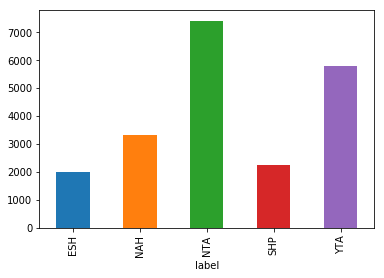

In [303]:
datas = pd.DataFrame(data=data.T, columns = ['id', 'title', 'label', 'bodies'])
datas.set_index('id')
datas[400:410]
datas.groupby("label")['id'].count().plot.bar()

In [304]:
from sklearn.model_selection import train_test_split
def split(inputs, labels):
    title, title_t, label, label_t = train_test_split(inputs, labels)
    title_tr, title_v, label_tr, label_v= train_test_split(title, label)
    
    return title, title_t, title_tr, title_v, label, label_t, label_tr, label_v

In [305]:
title, title_t, title_tr, title_v, label, label_t, label_tr, label_v = split(titles, labels)

In [306]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def vectorize(title, title_t, title_tr, title_v):
    vectorizer = CountVectorizer()

    #With this I create a vectorizer and fit it on all questions
    vectorizer.fit(titles)
    #Here I transform the vectorizer with the specific questions, depending on if it will 
    #be used on the training, validation or all questions
    vectors = []
        
    title_tr_en = vectorizer.transform(title_tr).toarray()
    title_v_en = vectorizer.transform(title_v).toarray()
    title_en = vectorizer.transform(title).toarray()
    title_t_en = vectorizer.transform(title_t).toarray()
    
    return vectorizer, title_en, title_t_en, title_tr_en, title_v_en

In [307]:
vectorizer, title_en, title_t_en, title_tr_en, title_v_en = vectorize(title, title_t, title_tr, title_v)
print(title_en.shape)
print(title_t_en.shape)
print(title_tr_en.shape)
print(title_v_en.shape)
#Here I create a Multinomial Naïve Bayes and train it on the training set
model = MultinomialNB()
model.fit(title_tr_en, label_tr)

(15616, 10053)
(5206, 10053)
(11712, 10053)
(3904, 10053)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [308]:
from sklearn.metrics import precision_recall_fscore_support
from numpy import vstack

def NB_validate(value_tr_en, value_v_en, label_tr, label_v, model):
    precision_v = np.array([0, 0])
    recall_v = np.array([0, 0])
    f_v = np.array([0, 0])

    for i in range(0,21, 1):
        alpha = i/10
        model.set_params(alpha = alpha)
        model.fit(value_tr_en, label_tr)
        prediction = model.predict(value_v_en)
        test = precision_recall_fscore_support(label_v, prediction, average='macro')
        precision_v = vstack((precision_v, (alpha, test[0])))
        recall_v = vstack((recall_v, (alpha, test[1])))
        f_v = vstack((f_v, (alpha, test[2])))

    return [precision_v, recall_v, f_v]


In [309]:
def visualize_validation(measures):
    precision_v = measures[0]
    recall_v = measures[1]
    f_v = measures[2]
    x3 = precision_v[1:-1, 0]
    x1 = recall_v[1:, 0]
    x2 = f_v[1:-1, 0]

    y3 = precision_v[1:-1, 1]
    y1 = recall_v[1:, 1]
    y2 = f_v[1:-1, 1]

    # Create plots with pre-defined labels.
    fig, ax = plt.subplots()
    ax.plot(x1, y1, '.-', label='Recall')
    ax.plot(x2, y2, 'r--', label='F')
    ax.plot(x3, y3, 'o-', label='Precision')

    legend = ax.legend(fontsize='x-large')

    def npmax(y1, y2, y3):
        max_y = 0
        max_i = 0
        for i,y in enumerate(y1):
            y = 0.1*y + 0.1*y2[i-1] + 0.8*y3[i-1]
            if y > max_y:
                max_y = y
                max_i = i

        return (max_i, max_y)

    acc_i, acc_max = npmax(y1, y2, y3)
    max_alpha = x3[acc_i-1]
    
    return max_alpha

/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


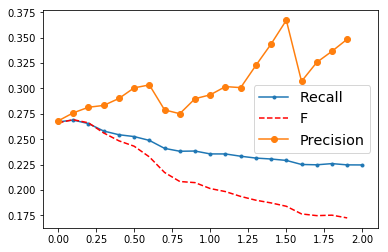

In [310]:

stats = NB_validate(title_tr_en, title_v_en, label_tr, label_v, model)
alpha = visualize_validation(stats)

In [311]:
model.set_params(alpha = 0.5)
model.fit(title_en, label)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [312]:
pred_t = model.predict(title_t_en)

print(precision_recall_fscore_support(label_t, pred_t, average='macro'))
print(precision_recall_fscore_support(label_t, pred_t, average='micro'))


#print("Accuracy = " + str((tp+tn)/(len(y_test))))
#print("Precision = "+ str(tp/(tp+fp)))
#print("Recall = "+ str(tp/(tp+fn)))
#print("F1 = "+ str(2*tp/(2*tp+fp +fn)))
q = vectorizer.transform(['AITA for failing my students', 'AITA for hating jews', 'AITA for hating C']).toarray()
print(model.predict(q))



(0.2572986078066235, 0.24101383230997006, 0.22927411636951223, None)
(0.3457548981943911, 0.3457548981943911, 0.3457548981943911, None)
['NTA' 'YTA' 'NTA']


{'a': 2, 'b': 3}


{'b': 3}
